# Analisis exploratorio de los datos
Primero importamos librerias y datos a ser usados

In [28]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#CREACION DE FATA FRAMES
df_metadata = pd.read_csv("c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Metadata.csv")
df_data_type = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Tabla Normalizada - Performances.csv')



## 1. grafico de barra por año para modelos categoriales y dimensionales

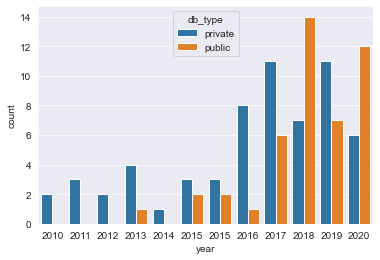

In [29]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

#ploteo
category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
sns.set_style('darkgrid')
sns.countplot(x='year', 
    data= df_data_type_sin_duplicates, 
    hue='db_type', 
    order=category_order)
plt.show()

## 2. subsetear para quedarnos con modelos dimensionales(columna affective model), subsetear con regressor, donde nos quedamos solo con las dimensiones que sean arousal/valence, quedarse con la medida de perforrmace que mas aparezca (count), hacer el test estadístico correspondiente (t, wettney, etc)


## 3. subsetear para quedarnos con modelos dimensionales(columna affective model), quedarse solo con clasificación binarias (LA,HA/LV,HV), quedarse con la medida de performance que mas aparezca (hacer count). hacer el test estadístico correspondiente (t, wettney, etc), que depende del supuesto (si hay normalidad se aplica paramétrico, sino no-parametrico). 

## 4. frencuencia de los modelos algortimicos 

## 5. frencuencia de los tipos de elicitation (por modalidad o tecnica especifica)

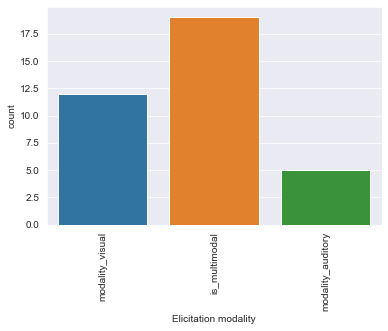

In [40]:
#frecuencia tipos elicitation por modalidad

df_emotion_elicitation_techniques=df_emotion_elicitation_techniques.fillna('-')
df_emotion_elicitation_techniques_sin_duplicates = df_emotion_elicitation_techniques.drop_duplicates(subset='paper_id')

df_eli_modalidad = df_emotion_elicitation_techniques_sin_duplicates.iloc[:,3:7]
def get_value(row):
     for c in df_eli_modalidad.columns:
         if row[c]== 'x':
             return c

df_eli_modalidad = df_eli_modalidad.apply(get_value, axis=1)
df_eli_modalidad = pd.DataFrame(df_eli_modalidad)
df_eli_modalidad.columns = ['Elicitation modality']

sns.countplot(x='Elicitation modality', data=df_eli_modalidad)
plt.xticks(rotation=90)
plt.show()

## 6. grafico de barra por año para tipos de base de datos

## 7. frencuencia por base de datos
Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas

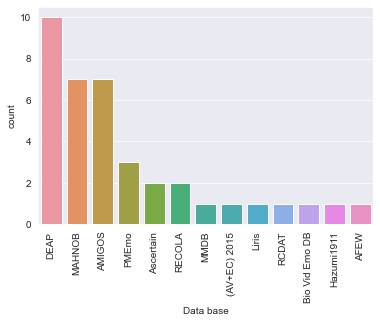

In [50]:
#bases de datos
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db = df_data_type_sin_duplicates.iloc[:,10:]
def get_value(row):
     for c in df_db.columns:
         if row[c]== 'x':
             return c

df_db = df_db.apply(get_value, axis=1)
df_db = pd.DataFrame(df_db)

#df_metadata_sources['source_type_journal']= df_metadata_sources['source_type_journal'].replace("x", "Journal") 


df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB'),
df_db.columns = ['Data base']

category_order = ['DEAP', 'MAHNOB', 'AMIGOS', 'PMEmo', 'Ascertain', 'RECOLA', 'MMDB', '(AV+EC) 2015', 'Liris','RCDAT','Bio Vid Emo DB','Hazumi1911','AFEW']
sns.countplot(x='Data base', data=df_db, order = category_order)
plt.xticks(rotation=90)
plt.show()

## 8. frecuencia journal, por si es ingeniería o no

c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


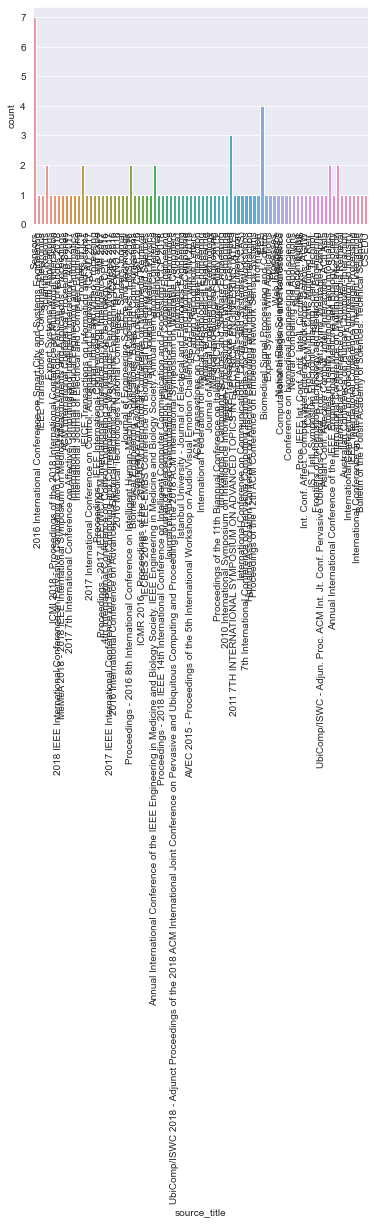

In [42]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_sin_duplicates[['paper_id','source_title']]
sns.countplot(x='source_title', data=df_source_title)
plt.xticks(rotation=90)
plt.show()

## 9. Analisis extras